In [1]:
%%capture
cd ..

In [2]:
from palma import datasets
from sklearn.preprocessing import OrdinalEncoder

In [3]:
X, y = datasets.load_credit_approval()

/tmp/ipykernel_1396279/174580055.py:17: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



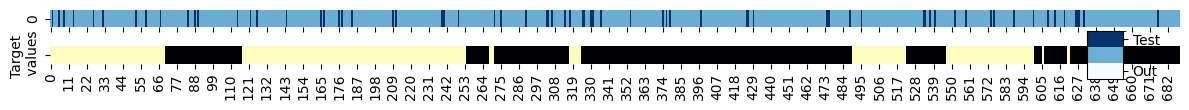

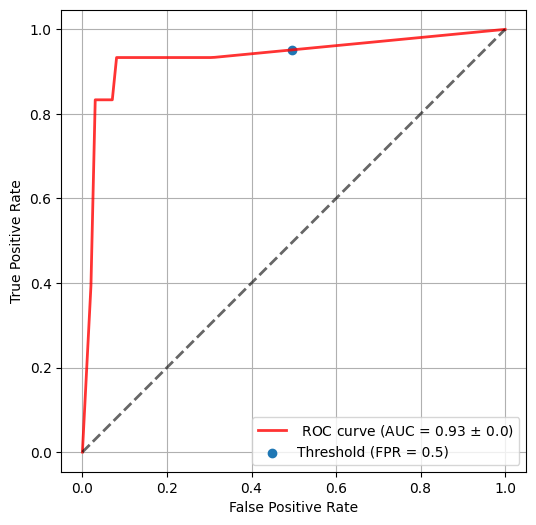

In [4]:
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics
from palma import Project, ModelEvaluation, ModelSelector
from palma.components import ScoringAnalysis, ShapAnalysis
from palma.utils import plotting


project = Project(problem="classification", project_name="test")
project.start(
    X, y,
    splitter=model_selection.ShuffleSplit(n_splits=4, random_state=42),
)

plotting.plot_splitting_strategy(
    project.X, project.y,
    iter_cross_validation=project.validation_strategy.indexes_train_test, cmap="rainbow_r")
plt.tight_layout()

ms = ModelSelector(engine="FlamlOptimizer",
                   engine_parameters=dict(
                       time_budget=10,
                       estimator_list=['lgbm', 'rf', 'xgboost']))
ms.start(project)

model = ModelEvaluation(estimator=ms.best_model_)
model.add(ScoringAnalysis(on="indexes_train_test"), name='test')
model.fit(project)

analyser = model.components["test"]

analyser.compute_threshold(method="fpr", value=0.5)

plt.figure(figsize=(6, 6))
analyser.plot_roc_curve()
analyser.plot_threshold(label="Threshold (FPR = 0.5)")
plt.legend(loc=4)

In [5]:
analyser.confusion_matrix(in_percentage=True)

,predicted : 0,predicted : 1
real : 0,37.7,18.8
real : 1,0.0,43.5


In [6]:
analyser.compute_threshold(method="total_population", value=0.5)
analyser.confusion_matrix(in_percentage=True)

,predicted : 0,predicted : 1
real : 0,36.2,20.3
real : 1,0.0,43.5


In [7]:
analyser.compute_threshold(method="optimize_metric",  metric=metrics.f1_score)
analyser.confusion_matrix(in_percentage=True)

,predicted : 0,predicted : 1
real : 0,50.7,5.8
real : 1,7.2,36.2


In [8]:
analyser.compute_threshold(method="optimize_metric",  metric=lambda x, y: metrics.fbeta_score(x, y, beta=10))
analyser.confusion_matrix(in_percentage=True)

,predicted : 0,predicted : 1
real : 0,50.7,5.8
real : 1,7.2,36.2
